
=== Running test config: Req10_Veh2_Reg0.05 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req20_Veh4_Reg0.1 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req30_Veh6_Reg0.2 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



--- Raw Results (All Configurations) ---
               Config  NumRequests  NumVehicles  RegionSize  distance_miles  \
0  Req10_Veh2_Reg0.05           10            2        0.05          35.139   
1   Req20_Veh4_Reg0.1           20            4        0.10          78.502   
2   Req30_Veh6_Reg0.2           30            6        0.20         197.705   

   sim_time_min  
0        70.278  
1       157.004  
2       395.410  


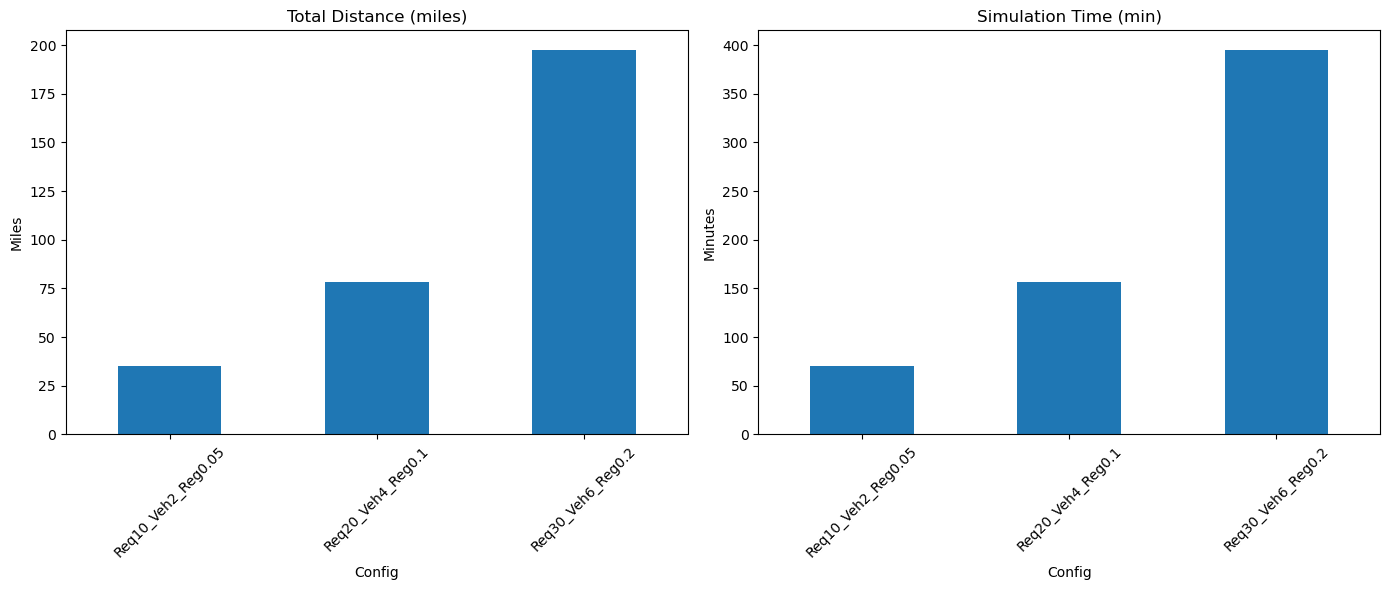

Basic grouped bar chart saved to grouped_comparison.png
Results page saved to results.html


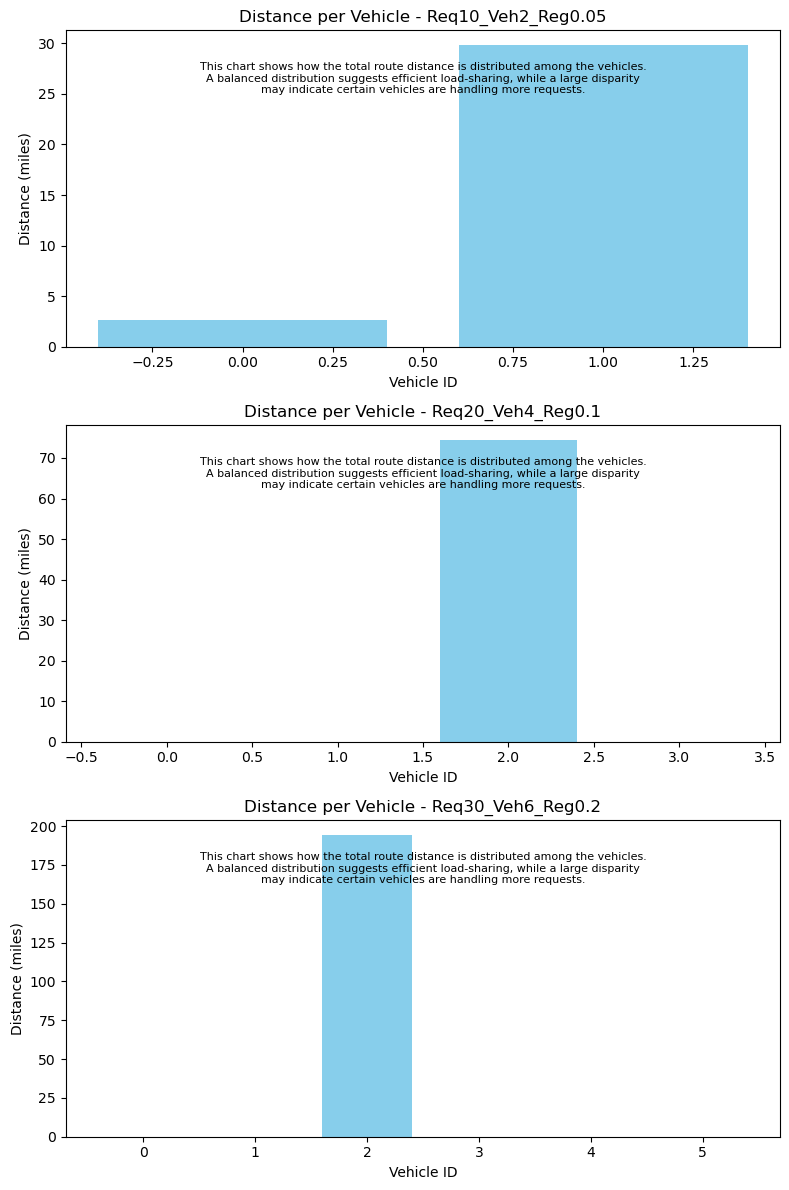

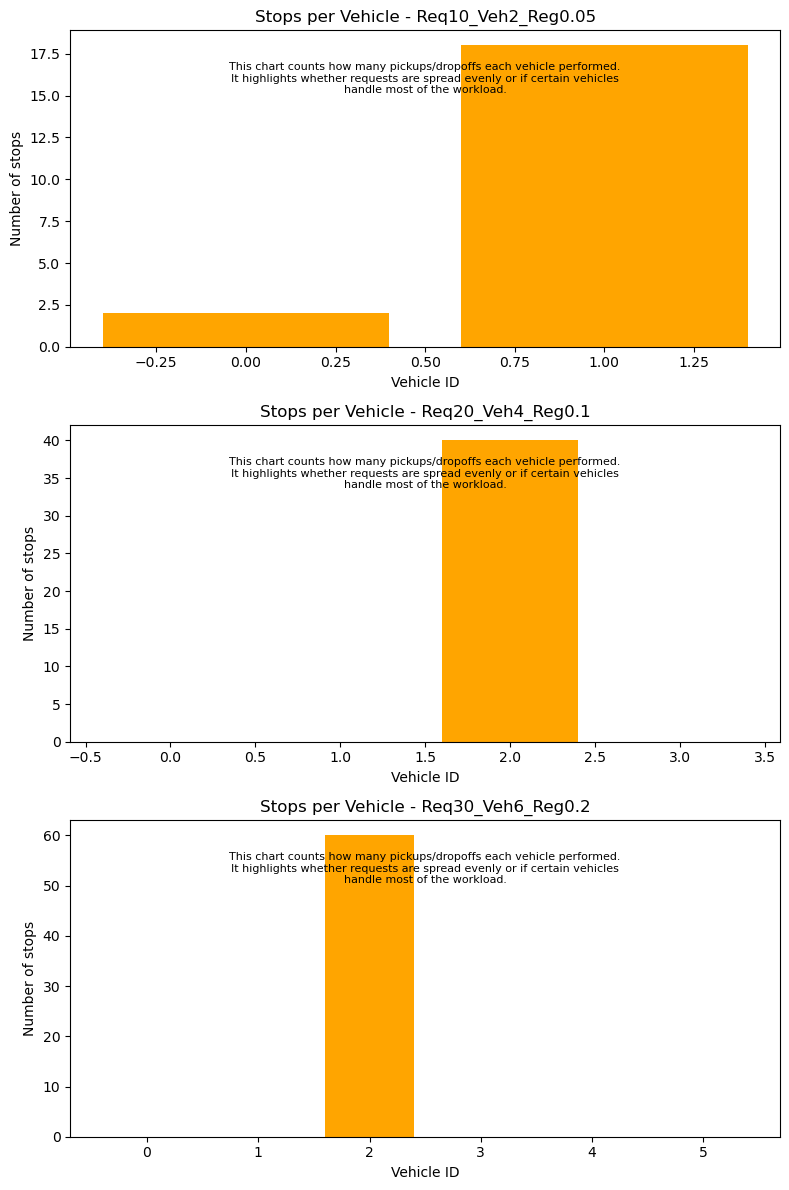

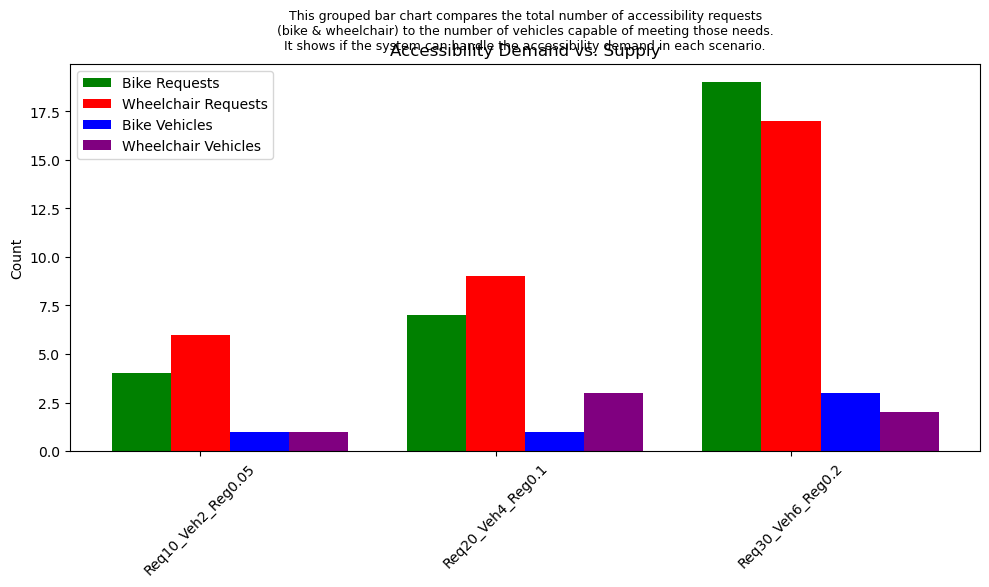

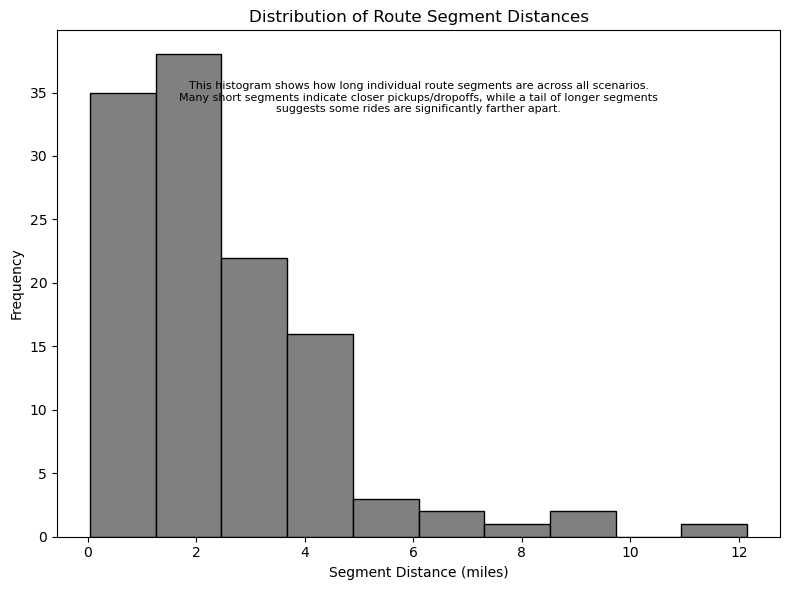

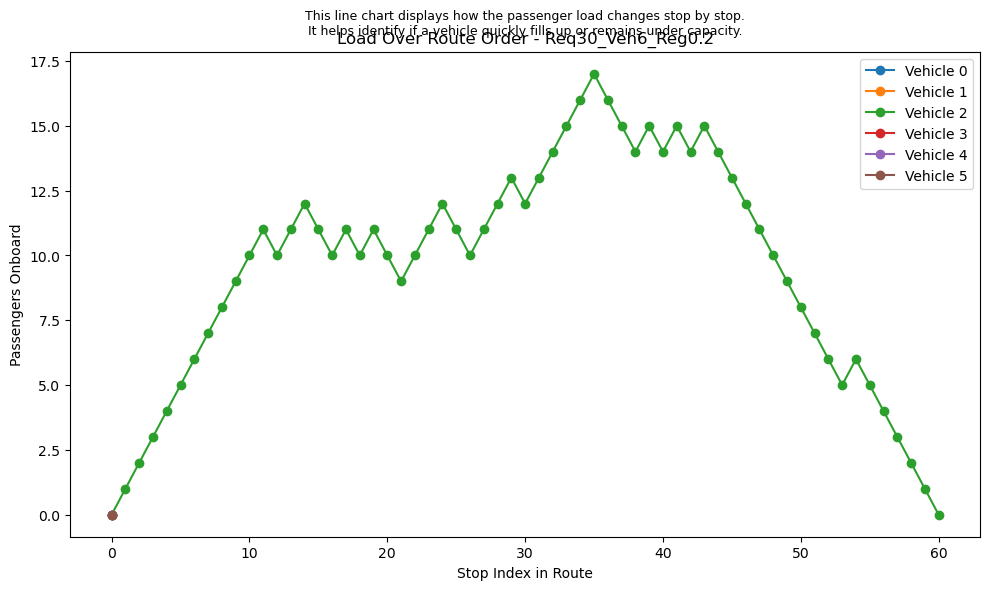

In [1]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

###############################################################################
# 1) SCENARIO DEFINITIONS (Case Studies)
###############################################################################
# We define three scenarios to reflect small, medium, and large region demands.
# Each scenario can be repeated or slightly changed if you want multiple runs.
TEST_CONFIGS = [
    # Case Study A: small region, fewer requests
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05},
    # Case Study B: moderate region, moderate requests
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    # Case Study C: larger region, more requests
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
]
TIME_LIMIT_SEC = 30  # Increase if needed

###############################################################################
# 2) DATA CREATION (RANDOM)
###############################################################################
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities.
    Randomness ensures each run is unique. We do not fix seeds here.
    """
    import numpy as np
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = region_size
    lon_range = region_size

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {}

    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)

        # Full-day time windows
        window = (0, 1440)

        needs_bike = (random.random() < 0.5)
        needs_wheelchair = (random.random() < 0.5)
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list
    for i, req in enumerate(requests):
        # pickup
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        # dropoff
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        # Store accessibility for pickup node only
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    # Large capacity to avoid capacity constraints overshadowing the test
    data["vehicle_capacities"] = [9999] * num_vehicles

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    # Time matrix based on 30 mph
    time_mat = (dist_mat / 30.0) * 60.0
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window
    data["time_windows"].append((0, 1440))
    
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Vehicle accessibility with 50% chance each
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = (random.random() < 0.5)
        wheelchair_accessible = (random.random() < 0.5)
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    
    return data, locations, passenger_node_to_name, accessibility_requirements, requests

###############################################################################
# 3) SOLVE ROUTING
###############################################################################
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Solves the routing problem with no skipping. 
    Returns metrics and the route for each vehicle.
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        return data["distance_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    def demand_callback(from_index):
        return data["demands"][manager.IndexToNode(from_index)]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    def time_callback(from_index, to_index):
        return data["time_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30000, 24*60*60*1000, False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0]*60000, tw[1]*60000)
    
    # Pickup and Delivery
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Accessibility constraints
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and not vehicle["bike_capable"]:
                continue
            if needs_wheelchair and not vehicle["wheelchair_accessible"]:
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GREEDY_DESCENT
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, None
    
    # Extract routes
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            route_nodes.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    # Calculate total distance
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    # Gather vehicle details
    vehicle_details = []
    route_segment_distances = []
    for v, route in enumerate(routes):
        route_dist = 0.0
        non_depot_stops = 0
        load_over_route = []
        current_load = 0
        for i in range(len(route)-1):
            from_node = route[i]
            to_node = route[i+1]
            dist_leg = data["distance_matrix"][from_node][to_node] / 1000.0
            route_dist += dist_leg
            route_segment_distances.append(dist_leg)
            current_load += data["demands"][from_node]
            load_over_route.append(current_load)
            if from_node != data["depot"]:
                non_depot_stops += 1
        if route:
            last_node = route[-1]
            current_load += data["demands"][last_node]
            load_over_route.append(current_load)
            if last_node != data["depot"]:
                non_depot_stops += 1
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist,
            "stops": non_depot_stops,
            "load_list": load_over_route
        })
    
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])
    
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes

###############################################################################
# 4) VISUALIZATION (MAP)
###############################################################################
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, vehicle_colors):
    """
    Creates a Folium map with always-visible labels (DivIcon).
    """
    from folium.features import DivIcon
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)

    # Attempt to create an OSM graph for route directions
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print("OSMnx error, using direct coords only:", e)
        G = None

    for v_idx, route in enumerate(routes):
        color = vehicle_colors[v_idx % len(vehicle_colors)]
        coords = [(locations[node_idx][1], locations[node_idx][2]) for node_idx in route]
        folium.PolyLine(coords, color=color, weight=3).add_to(m)
        
        # Label each stop with a DivIcon
        for stop_order, node_idx in enumerate(route, start=1):
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            if dem == 1:
                point_type = "Pickup"
                request_name = passenger_node_to_name.get(node_idx, "?")
            elif dem == -1:
                point_type = "Dropoff"
                request_name = passenger_node_to_name.get(node_idx, "?")
            else:
                point_type = "Depot"
                request_name = "Depot"
            
            needs_bike, needs_wheelchair = accessibility_requirements.get(node_idx, (False, False))
            icon_str = ""
            if needs_bike:
                icon_str += " 🚲"
            if needs_wheelchair:
                icon_str += " ♿"
            
            label_text = f"Bus #{v_idx}, Stop #{stop_order}, {point_type} {request_name}{icon_str}"
            offset_lat = 0.00005
            offset_lon = 0.00005
            folium.map.Marker(
                location=(lat + offset_lat, lon + offset_lon),
                icon=DivIcon(
                    icon_size=(250, 36),
                    icon_anchor=(0, 0),
                    html=f"""
                    <div style="font-size: 10pt; 
                                color: white; 
                                background-color: {color}; 
                                opacity: 0.8;
                                border: 1px solid black; 
                                border-radius: 4px;
                                padding: 2px;">
                        {label_text}
                    </div>
                    """
                )
            ).add_to(m)
    
    return m

###############################################################################
# 5) BUILD RESULTS PAGE (HTML)
###############################################################################
def build_results_page(df, map_files, chart_file):
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<p>Below are the aggregated metrics from our three case studies, each representing a distinct scenario in terms of number of requests, vehicles, and region size.</p>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart (Basic)</h2><p>This bar chart compares total distance (left) and simulation time (right) across the scenarios. We see how the system scales with the number of requests and region size.</p>"
    html += f"<img src='{chart_file}' alt='Grouped Bar Chart' style='max-width:800px;'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a> - View the Folium map for this scenario.</li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

###############################################################################
# 6) ANALYZE AND PLOT (CHARTS WITH DESCRIPTIONS)
###############################################################################
def analyze_and_plot(all_runs_data):
    """
    Creates charts to illustrate:
      - Distance per vehicle
      - Stops per vehicle
      - Accessibility demand vs. supply
      - Distribution of route segment distances
      - Load over route order
    Each chart is accompanied by a textual explanation.
    """
    import numpy as np
    
    scenario_labels = []
    all_vehicle_distances = []
    all_vehicle_stops = []
    bike_requests_list = []
    wheelchair_requests_list = []
    bike_vehicles_list = []
    wheelchair_vehicles_list = []
    all_segment_dists = []
    load_charts_data = None
    load_charts_label = None
    
    # Gather data from each scenario
    for scenario_data in all_runs_data:
        scenario_label = scenario_data["Config"]
        scenario_labels.append(scenario_label)
        
        v_dists = [v["route_distance"] for v in scenario_data["vehicle_details"]]
        v_stops = [v["stops"] for v in scenario_data["vehicle_details"]]
        
        all_vehicle_distances.append(v_dists)
        all_vehicle_stops.append(v_stops)
        
        bike_requests_list.append(scenario_data["bike_requests"])
        wheelchair_requests_list.append(scenario_data["wheelchair_requests"])
        bike_vehicles_list.append(scenario_data["bike_vehicles"])
        wheelchair_vehicles_list.append(scenario_data["wheelchair_vehicles"])
        
        all_segment_dists.extend(scenario_data["segment_distances"])
        
        # We'll store the last scenario's data for the "Load Over Route" chart
        load_charts_data = scenario_data["vehicle_details"]
        load_charts_label = scenario_label
    
    # 1) Distance per Vehicle by Scenario
    fig1, axes1 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes1 = [axes1]
    for idx, label in enumerate(scenario_labels):
        ax = axes1[idx]
        dist_list = all_vehicle_distances[idx]
        ax.bar(range(len(dist_list)), dist_list, color='skyblue')
        ax.set_title(f"Distance per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Distance (miles)")
        # Explanation
        ax.text(0.5, 0.9, 
                "This chart shows how the total route distance is distributed among the vehicles.\n"
                "A balanced distribution suggests efficient load-sharing, while a large disparity\n"
                "may indicate certain vehicles are handling more requests.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("distance_per_vehicle.png")
    plt.show()
    
    # 2) Stops per Vehicle by Scenario
    fig2, axes2 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes2 = [axes2]
    for idx, label in enumerate(scenario_labels):
        ax = axes2[idx]
        stops_list = all_vehicle_stops[idx]
        ax.bar(range(len(stops_list)), stops_list, color='orange')
        ax.set_title(f"Stops per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Number of stops")
        # Explanation
        ax.text(0.5, 0.9,
                "This chart counts how many pickups/dropoffs each vehicle performed.\n"
                "It highlights whether requests are spread evenly or if certain vehicles\n"
                "handle most of the workload.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("stops_per_vehicle.png")
    plt.show()
    
    # 3) Accessibility Demand vs. Supply (Grouped Bar)
    x = range(len(scenario_labels))
    width = 0.2
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.bar([xi - width for xi in x], bike_requests_list, width=width, label="Bike Requests", color='green')
    ax3.bar(x, wheelchair_requests_list, width=width, label="Wheelchair Requests", color='red')
    ax3.bar([xi + width for xi in x], bike_vehicles_list, width=width, label="Bike Vehicles", color='blue')
    ax3.bar([xi + 2*width for xi in x], wheelchair_vehicles_list, width=width, label="Wheelchair Vehicles", color='purple')
    ax3.set_xticks(list(x))
    ax3.set_xticklabels(scenario_labels, rotation=45)
    ax3.set_ylabel("Count")
    ax3.set_title("Accessibility Demand vs. Supply")
    ax3.legend()
    # Explanation
    ax3.text(0.5, 1.03,
             "This grouped bar chart compares the total number of accessibility requests\n"
             "(bike & wheelchair) to the number of vehicles capable of meeting those needs.\n"
             "It shows if the system can handle the accessibility demand in each scenario.",
             transform=ax3.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("accessibility_demand_vs_supply.png")
    plt.show()
    
    # 4) Distribution of Route Segment Distances (Histogram)
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    ax4.hist(all_segment_dists, bins=10, color='gray', edgecolor='black')
    ax4.set_title("Distribution of Route Segment Distances")
    ax4.set_xlabel("Segment Distance (miles)")
    ax4.set_ylabel("Frequency")
    # Explanation
    ax4.text(0.5, 0.9,
             "This histogram shows how long individual route segments are across all scenarios.\n"
             "Many short segments indicate closer pickups/dropoffs, while a tail of longer segments\n"
             "suggests some rides are significantly farther apart.",
             transform=ax4.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("segment_distance_hist.png")
    plt.show()
    
    # 5) Load Over Route Order (Line Chart) - from the last scenario
    if load_charts_data is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        for vinfo in load_charts_data:
            v_id = vinfo["vehicle_id"]
            load_list = vinfo["load_list"]
            ax5.plot(range(len(load_list)), load_list, marker='o', label=f"Vehicle {v_id}")
        ax5.set_title(f"Load Over Route Order - {load_charts_label}")
        ax5.set_xlabel("Stop Index in Route")
        ax5.set_ylabel("Passengers Onboard")
        ax5.legend()
        # Explanation
        ax5.text(0.5, 1.03,
                 "This line chart displays how the passenger load changes stop by stop.\n"
                 "It helps identify if a vehicle quickly fills up or remains under capacity.",
                 transform=ax5.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')
        plt.tight_layout()
        plt.savefig("load_over_route.png")
        plt.show()

###############################################################################
# 7) MAIN: RUN CASE STUDIES, PLOT, & GENERATE RESULTS
###############################################################################
def main():
    all_runs = []
    map_files = {}
    
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        # Create random data for this scenario
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)
        
        # Solve routing
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        # Store scenario-level info
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            "requests": requests
        })
        all_runs.append(metrics)
        
        # Create a map for each scenario
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        vehicle_colors = ['red', 'blue', 'green', 'purple', 'orange']
        my_map = visualize_routes(routes, data, locations, passenger_node_to_name,
                                  accessibility_requirements, vehicle_colors)
        my_map.save(mapfile)
        map_files[config_label] = mapfile
        
        # Display inline if in Jupyter
        if IN_JUPYTER:
            display(my_map)
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    # Build a DataFrame of the main metrics for each scenario
    df = pd.DataFrame([
        {
            "Config": r["Config"],
            "NumRequests": r["NumRequests"],
            "NumVehicles": r["NumVehicles"],
            "RegionSize": r["RegionSize"],
            "distance_miles": r["distance_miles"],
            "sim_time_min": r["sim_time_min"]
        } for r in all_runs
    ])
    
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    # Basic bar charts for total distance & sim time
    df_indexed = df.set_index("Config")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Basic grouped bar chart saved to {chart_filename}")
    
    # Build HTML results page
    build_results_page(df, map_files, chart_filename)
    
    # Create additional analysis & charts with textual explanations
    analyze_and_plot(all_runs)

if __name__ == "__main__":
    main()


In [1]:
The kernel for Documents/GitHub/GoEveryWhere-Darp-Algorithm/Algorithms/darp-v10.ipynb appears to have died. It will restart automatically.

SyntaxError: invalid syntax (2999465182.py, line 1)


=== Running test config: Req10_Veh2_Reg0.05 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req20_Veh4_Reg0.1 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req30_Veh6_Reg0.2 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



--- Raw Results (All Configurations) ---
               Config  NumRequests  NumVehicles  RegionSize  distance_miles  \
0  Req10_Veh2_Reg0.05           10            2        0.05          27.950   
1   Req20_Veh4_Reg0.1           20            4        0.10         104.777   
2   Req30_Veh6_Reg0.2           30            6        0.20         203.366   

   sim_time_min  
0        55.900  
1       209.554  
2       406.732  


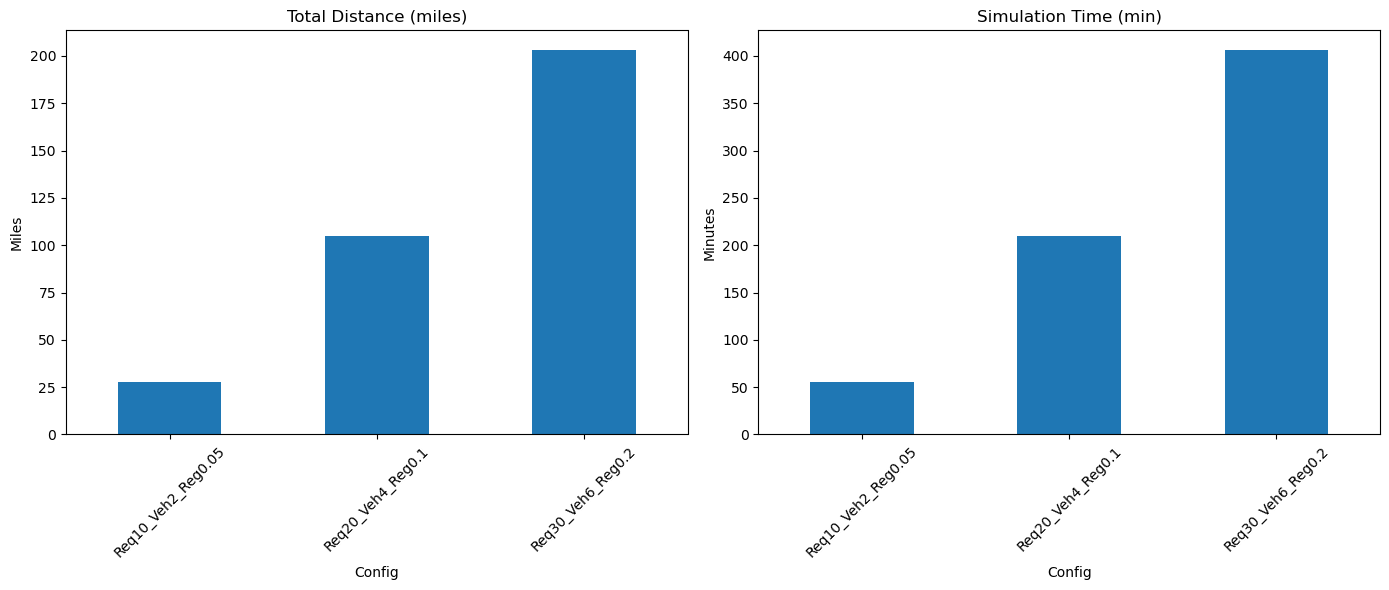

Basic grouped bar chart saved to grouped_comparison.png
Results page saved to results.html


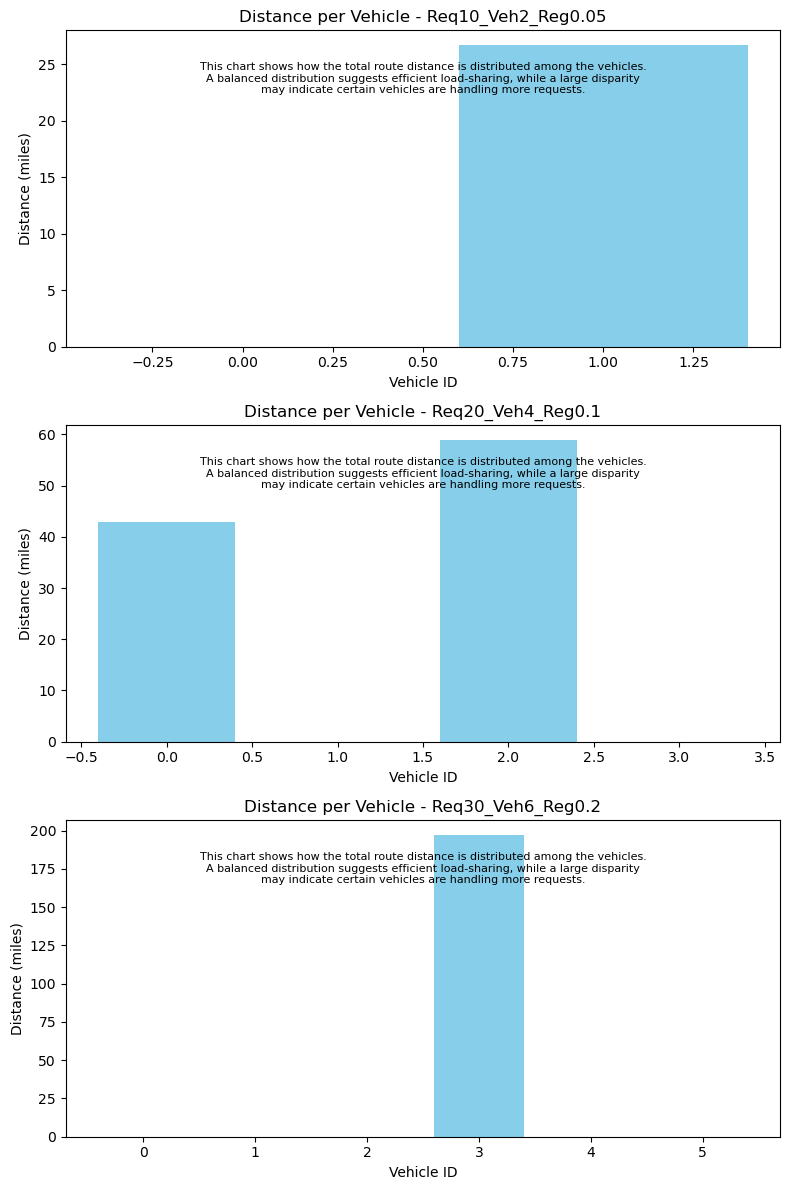

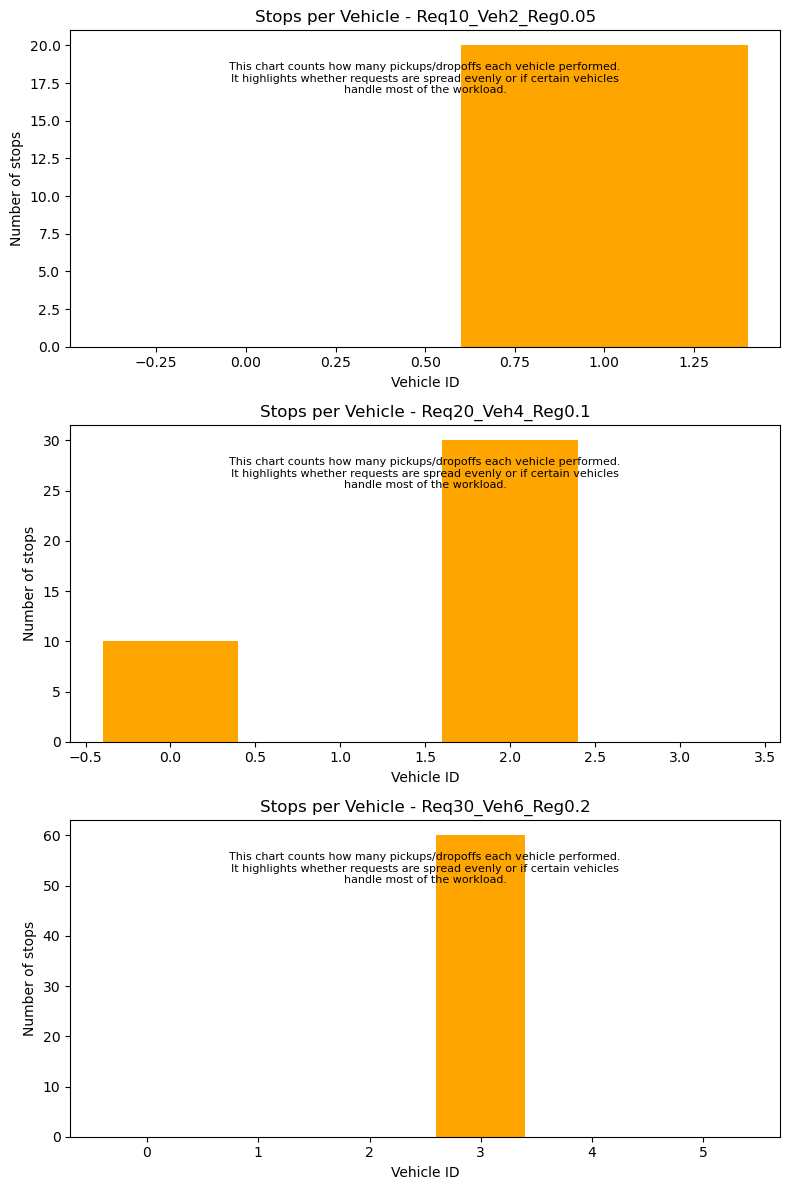

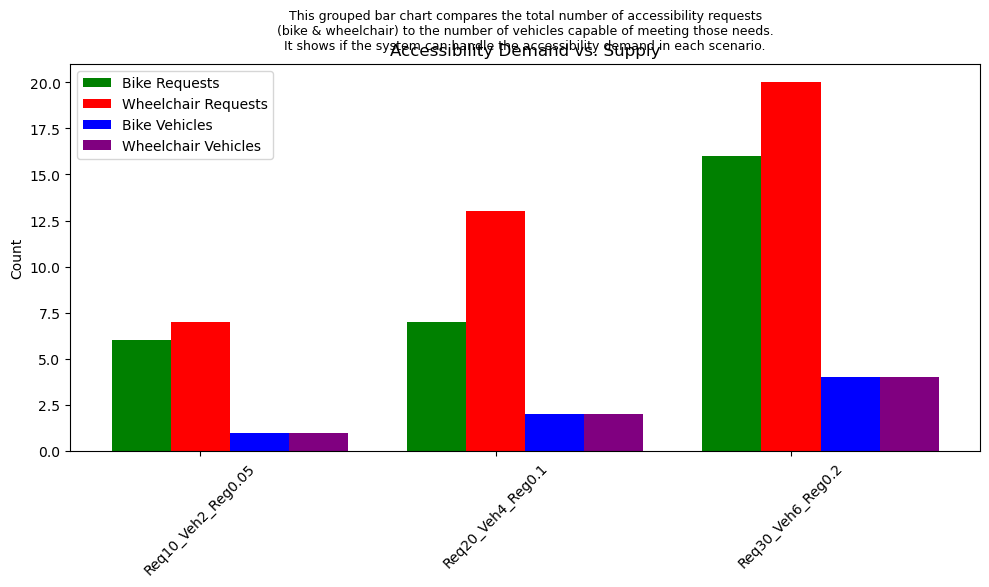

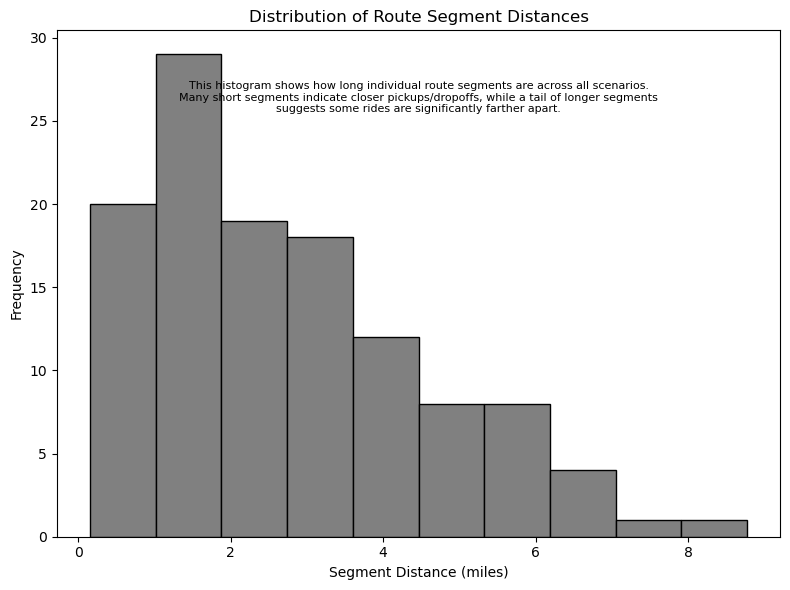

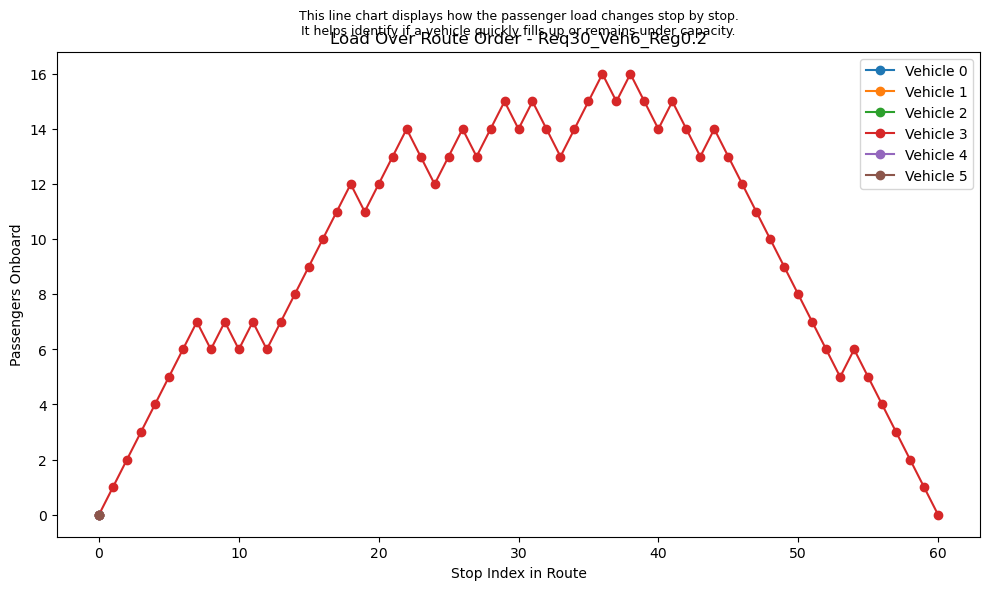

In [3]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

###############################################################################
# 1) SCENARIO DEFINITIONS (Case Studies)
###############################################################################
# We define three scenarios to reflect small, medium, and large region demands.
# Each scenario can be repeated or slightly changed if you want multiple runs.
TEST_CONFIGS = [
    # Case Study A: small region, fewer requests
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05},
    # Case Study B: moderate region, moderate requests
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    # Case Study C: larger region, more requests
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
]
TIME_LIMIT_SEC = 30  # Increase if needed

###############################################################################
# 2) DATA CREATION (RANDOM)
###############################################################################
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities.
    Randomness ensures each run is unique. We do not fix seeds here.
    """
    import numpy as np
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = region_size
    lon_range = region_size

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {}

    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)

        # Full-day time windows
        window = (0, 1440)

        needs_bike = (random.random() < 0.5)
        needs_wheelchair = (random.random() < 0.5)
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list
    for i, req in enumerate(requests):
        # pickup
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        # dropoff
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        # Store accessibility for pickup node only
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    # Large capacity to avoid capacity constraints overshadowing the test
    data["vehicle_capacities"] = [9999] * num_vehicles

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    # Time matrix based on 30 mph
    time_mat = (dist_mat / 30.0) * 60.0
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window
    data["time_windows"].append((0, 1440))
    
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Vehicle accessibility with 50% chance each
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = (random.random() < 0.5)
        wheelchair_accessible = (random.random() < 0.5)
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    
    return data, locations, passenger_node_to_name, accessibility_requirements, requests

###############################################################################
# 3) SOLVE ROUTING
###############################################################################
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Solves the routing problem with no skipping. 
    Returns metrics and the route for each vehicle.
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        return data["distance_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    def demand_callback(from_index):
        return data["demands"][manager.IndexToNode(from_index)]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    def time_callback(from_index, to_index):
        return data["time_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30000, 24*60*60*1000, False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0]*60000, tw[1]*60000)
    
    # Pickup and Delivery
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Accessibility constraints
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and not vehicle["bike_capable"]:
                continue
            if needs_wheelchair and not vehicle["wheelchair_accessible"]:
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, None
    
    # Extract routes
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            route_nodes.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    # Calculate total distance
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    # Gather vehicle details
    vehicle_details = []
    route_segment_distances = []
    for v, route in enumerate(routes):
        route_dist = 0.0
        non_depot_stops = 0
        load_over_route = []
        current_load = 0
        for i in range(len(route)-1):
            from_node = route[i]
            to_node = route[i+1]
            dist_leg = data["distance_matrix"][from_node][to_node] / 1000.0
            route_dist += dist_leg
            route_segment_distances.append(dist_leg)
            current_load += data["demands"][from_node]
            load_over_route.append(current_load)
            if from_node != data["depot"]:
                non_depot_stops += 1
        if route:
            last_node = route[-1]
            current_load += data["demands"][last_node]
            load_over_route.append(current_load)
            if last_node != data["depot"]:
                non_depot_stops += 1
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist,
            "stops": non_depot_stops,
            "load_list": load_over_route
        })
    
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])
    
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes

###############################################################################
# 4) VISUALIZATION (MAP)
###############################################################################
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, vehicle_colors):
    """
    Creates a Folium map with always-visible labels (DivIcon).
    """
    from folium.features import DivIcon
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)

    # Attempt to create an OSM graph for route directions
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print("OSMnx error, using direct coords only:", e)
        G = None

    for v_idx, route in enumerate(routes):
        color = vehicle_colors[v_idx % len(vehicle_colors)]
        coords = [(locations[node_idx][1], locations[node_idx][2]) for node_idx in route]
        folium.PolyLine(coords, color=color, weight=3).add_to(m)
        
        # Label each stop with a DivIcon
        for stop_order, node_idx in enumerate(route, start=1):
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            if dem == 1:
                point_type = "Pickup"
                request_name = passenger_node_to_name.get(node_idx, "?")
            elif dem == -1:
                point_type = "Dropoff"
                request_name = passenger_node_to_name.get(node_idx, "?")
            else:
                point_type = "Depot"
                request_name = "Depot"
            
            needs_bike, needs_wheelchair = accessibility_requirements.get(node_idx, (False, False))
            icon_str = ""
            if needs_bike:
                icon_str += " 🚲"
            if needs_wheelchair:
                icon_str += " ♿"
            
            label_text = f"Bus #{v_idx}, Stop #{stop_order}, {point_type} {request_name}{icon_str}"
            offset_lat = 0.00005
            offset_lon = 0.00005
            folium.map.Marker(
                location=(lat + offset_lat, lon + offset_lon),
                icon=DivIcon(
                    icon_size=(250, 36),
                    icon_anchor=(0, 0),
                    html=f"""
                    <div style="font-size: 10pt; 
                                color: white; 
                                background-color: {color}; 
                                opacity: 0.8;
                                border: 1px solid black; 
                                border-radius: 4px;
                                padding: 2px;">
                        {label_text}
                    </div>
                    """
                )
            ).add_to(m)
    
    return m

###############################################################################
# 5) BUILD RESULTS PAGE (HTML)
###############################################################################
def build_results_page(df, map_files, chart_file):
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<p>Below are the aggregated metrics from our three case studies, each representing a distinct scenario in terms of number of requests, vehicles, and region size.</p>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart (Basic)</h2><p>This bar chart compares total distance (left) and simulation time (right) across the scenarios. We see how the system scales with the number of requests and region size.</p>"
    html += f"<img src='{chart_file}' alt='Grouped Bar Chart' style='max-width:800px;'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a> - View the Folium map for this scenario.</li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

###############################################################################
# 6) ANALYZE AND PLOT (CHARTS WITH DESCRIPTIONS)
###############################################################################
def analyze_and_plot(all_runs_data):
    """
    Creates charts to illustrate:
      - Distance per vehicle
      - Stops per vehicle
      - Accessibility demand vs. supply
      - Distribution of route segment distances
      - Load over route order
    Each chart is accompanied by a textual explanation.
    """
    import numpy as np
    
    scenario_labels = []
    all_vehicle_distances = []
    all_vehicle_stops = []
    bike_requests_list = []
    wheelchair_requests_list = []
    bike_vehicles_list = []
    wheelchair_vehicles_list = []
    all_segment_dists = []
    load_charts_data = None
    load_charts_label = None
    
    # Gather data from each scenario
    for scenario_data in all_runs_data:
        scenario_label = scenario_data["Config"]
        scenario_labels.append(scenario_label)
        
        v_dists = [v["route_distance"] for v in scenario_data["vehicle_details"]]
        v_stops = [v["stops"] for v in scenario_data["vehicle_details"]]
        
        all_vehicle_distances.append(v_dists)
        all_vehicle_stops.append(v_stops)
        
        bike_requests_list.append(scenario_data["bike_requests"])
        wheelchair_requests_list.append(scenario_data["wheelchair_requests"])
        bike_vehicles_list.append(scenario_data["bike_vehicles"])
        wheelchair_vehicles_list.append(scenario_data["wheelchair_vehicles"])
        
        all_segment_dists.extend(scenario_data["segment_distances"])
        
        # We'll store the last scenario's data for the "Load Over Route" chart
        load_charts_data = scenario_data["vehicle_details"]
        load_charts_label = scenario_label
    
    # 1) Distance per Vehicle by Scenario
    fig1, axes1 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes1 = [axes1]
    for idx, label in enumerate(scenario_labels):
        ax = axes1[idx]
        dist_list = all_vehicle_distances[idx]
        ax.bar(range(len(dist_list)), dist_list, color='skyblue')
        ax.set_title(f"Distance per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Distance (miles)")
        # Explanation
        ax.text(0.5, 0.9, 
                "This chart shows how the total route distance is distributed among the vehicles.\n"
                "A balanced distribution suggests efficient load-sharing, while a large disparity\n"
                "may indicate certain vehicles are handling more requests.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("distance_per_vehicle.png")
    plt.show()
    
    # 2) Stops per Vehicle by Scenario
    fig2, axes2 = plt.subplots(len(scenario_labels), 1, figsize=(8, 4 * len(scenario_labels)))
    if len(scenario_labels) == 1:
        axes2 = [axes2]
    for idx, label in enumerate(scenario_labels):
        ax = axes2[idx]
        stops_list = all_vehicle_stops[idx]
        ax.bar(range(len(stops_list)), stops_list, color='orange')
        ax.set_title(f"Stops per Vehicle - {label}")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Number of stops")
        # Explanation
        ax.text(0.5, 0.9,
                "This chart counts how many pickups/dropoffs each vehicle performed.\n"
                "It highlights whether requests are spread evenly or if certain vehicles\n"
                "handle most of the workload.",
                transform=ax.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("stops_per_vehicle.png")
    plt.show()
    
    # 3) Accessibility Demand vs. Supply (Grouped Bar)
    x = range(len(scenario_labels))
    width = 0.2
    fig3, ax3 = plt.subplots(figsize=(10, 6))
    ax3.bar([xi - width for xi in x], bike_requests_list, width=width, label="Bike Requests", color='green')
    ax3.bar(x, wheelchair_requests_list, width=width, label="Wheelchair Requests", color='red')
    ax3.bar([xi + width for xi in x], bike_vehicles_list, width=width, label="Bike Vehicles", color='blue')
    ax3.bar([xi + 2*width for xi in x], wheelchair_vehicles_list, width=width, label="Wheelchair Vehicles", color='purple')
    ax3.set_xticks(list(x))
    ax3.set_xticklabels(scenario_labels, rotation=45)
    ax3.set_ylabel("Count")
    ax3.set_title("Accessibility Demand vs. Supply")
    ax3.legend()
    # Explanation
    ax3.text(0.5, 1.03,
             "This grouped bar chart compares the total number of accessibility requests\n"
             "(bike & wheelchair) to the number of vehicles capable of meeting those needs.\n"
             "It shows if the system can handle the accessibility demand in each scenario.",
             transform=ax3.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("accessibility_demand_vs_supply.png")
    plt.show()
    
    # 4) Distribution of Route Segment Distances (Histogram)
    fig4, ax4 = plt.subplots(figsize=(8, 6))
    ax4.hist(all_segment_dists, bins=10, color='gray', edgecolor='black')
    ax4.set_title("Distribution of Route Segment Distances")
    ax4.set_xlabel("Segment Distance (miles)")
    ax4.set_ylabel("Frequency")
    # Explanation
    ax4.text(0.5, 0.9,
             "This histogram shows how long individual route segments are across all scenarios.\n"
             "Many short segments indicate closer pickups/dropoffs, while a tail of longer segments\n"
             "suggests some rides are significantly farther apart.",
             transform=ax4.transAxes, fontsize=8, verticalalignment='top', horizontalalignment='center')
    plt.tight_layout()
    plt.savefig("segment_distance_hist.png")
    plt.show()
    
    # 5) Load Over Route Order (Line Chart) - from the last scenario
    if load_charts_data is not None:
        fig5, ax5 = plt.subplots(figsize=(10, 6))
        for vinfo in load_charts_data:
            v_id = vinfo["vehicle_id"]
            load_list = vinfo["load_list"]
            ax5.plot(range(len(load_list)), load_list, marker='o', label=f"Vehicle {v_id}")
        ax5.set_title(f"Load Over Route Order - {load_charts_label}")
        ax5.set_xlabel("Stop Index in Route")
        ax5.set_ylabel("Passengers Onboard")
        ax5.legend()
        # Explanation
        ax5.text(0.5, 1.03,
                 "This line chart displays how the passenger load changes stop by stop.\n"
                 "It helps identify if a vehicle quickly fills up or remains under capacity.",
                 transform=ax5.transAxes, fontsize=9, verticalalignment='bottom', horizontalalignment='center')
        plt.tight_layout()
        plt.savefig("load_over_route.png")
        plt.show()

###############################################################################
# 7) MAIN: RUN CASE STUDIES, PLOT, & GENERATE RESULTS
###############################################################################
def main():
    all_runs = []
    map_files = {}
    
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        # Create random data for this scenario
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)
        
        # Solve routing
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        # Store scenario-level info
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            "requests": requests
        })
        all_runs.append(metrics)
        
        # Create a map for each scenario
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        vehicle_colors = ['red', 'blue', 'green', 'purple', 'orange']
        my_map = visualize_routes(routes, data, locations, passenger_node_to_name,
                                  accessibility_requirements, vehicle_colors)
        my_map.save(mapfile)
        map_files[config_label] = mapfile
        
        # Display inline if in Jupyter
        if IN_JUPYTER:
            display(my_map)
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    # Build a DataFrame of the main metrics for each scenario
    df = pd.DataFrame([
        {
            "Config": r["Config"],
            "NumRequests": r["NumRequests"],
            "NumVehicles": r["NumVehicles"],
            "RegionSize": r["RegionSize"],
            "distance_miles": r["distance_miles"],
            "sim_time_min": r["sim_time_min"]
        } for r in all_runs
    ])
    
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    # Basic bar charts for total distance & sim time
    df_indexed = df.set_index("Config")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Basic grouped bar chart saved to {chart_filename}")
    
    # Build HTML results page
    build_results_page(df, map_files, chart_filename)
    
    # Create additional analysis & charts with textual explanations
    analyze_and_plot(all_runs)

if __name__ == "__main__":
    main()



=== Running test config: Req10_Veh2_Reg0.05 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req20_Veh4_Reg0.1 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



=== Running test config: Req30_Veh6_Reg0.2 ===


C:\Users\Laxad\anaconda3\Lib\site-packages\osmnx\graph.py:191: FutureWarning: The expected order of coordinates in `bbox` will change in the v2.0.0 release to `(left, bottom, right, top)`.
  G = graph_from_bbox(



--- Raw Results (All Configurations) ---
               Config  NumRequests  NumVehicles  RegionSize  distance_miles  \
0  Req10_Veh2_Reg0.05           10            2        0.05          30.384   
1   Req20_Veh4_Reg0.1           20            4        0.10          81.277   
2   Req30_Veh6_Reg0.2           30            6        0.20         195.304   

   sim_time_min  
0        60.768  
1       162.554  
2       390.608  


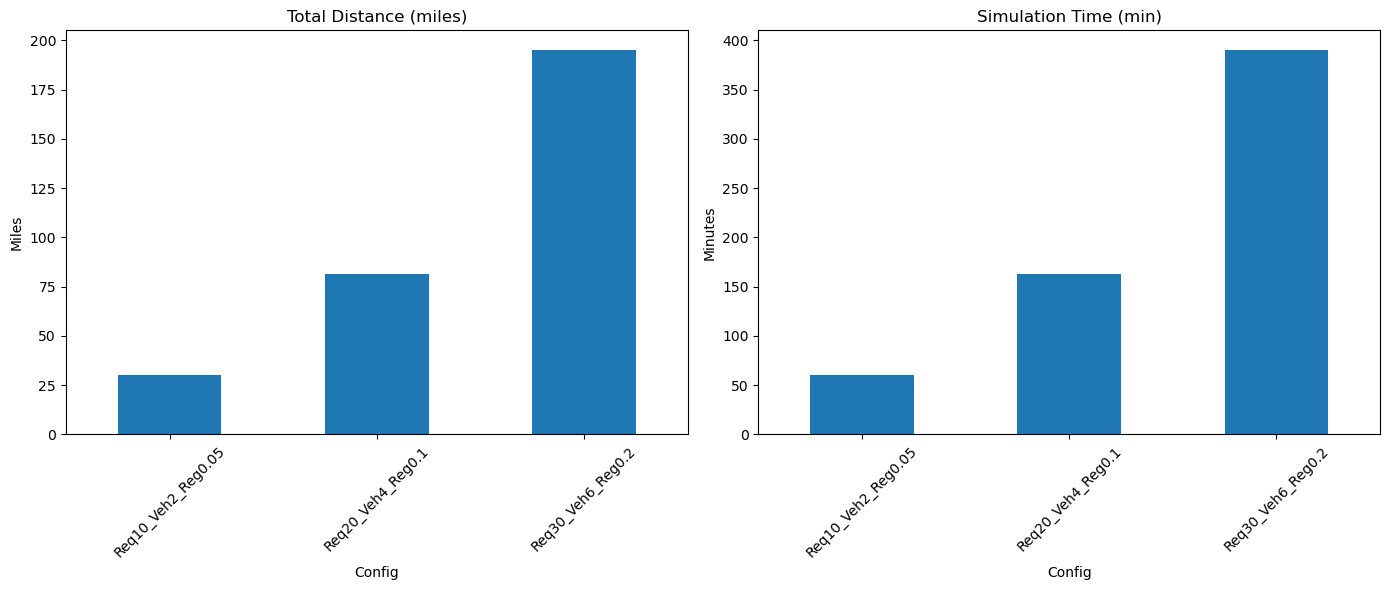

Basic grouped bar chart saved to grouped_comparison.png
Results page saved to results.html

================= ANALYTICS & CASE STUDIES =================
Below we examine each case study (scenario) individually.


--- Case Study #1: Req10_Veh2_Reg0.05 ---
Number of Requests: 10
Number of Vehicles: 2
Region Size: ±0.05 degrees
Total Distance (miles): 30.38
Simulation Time (minutes): 60.77
Bike Requests: 4, Wheelchair Requests: 6
Bike Vehicles: 2, Wheelchair Vehicles: 2


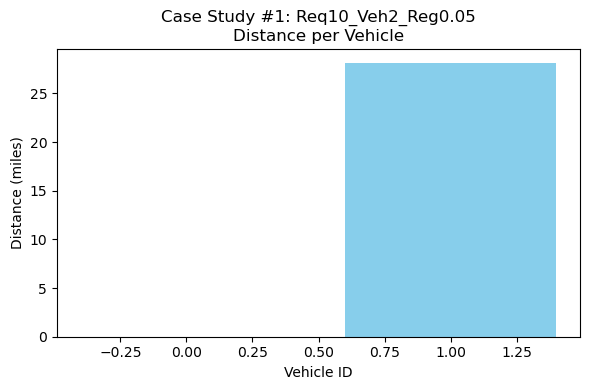

Chart Explanation: Shows how total route distance is distributed among vehicles.
A balanced distribution suggests efficient load-sharing, while large disparity indicates
certain vehicles handle more requests than others.



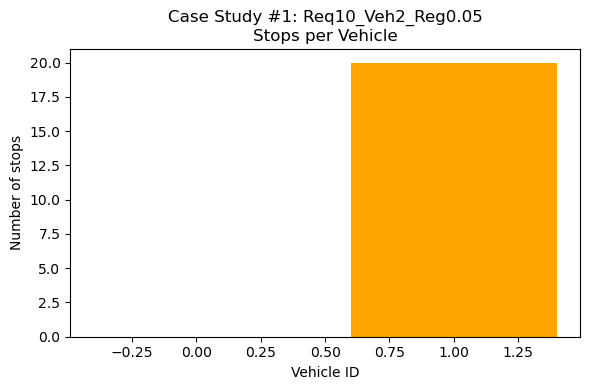

Chart Explanation: Shows how many pickups/dropoffs each vehicle performed.
It highlights whether requests are spread evenly or if certain vehicles do most of the work.



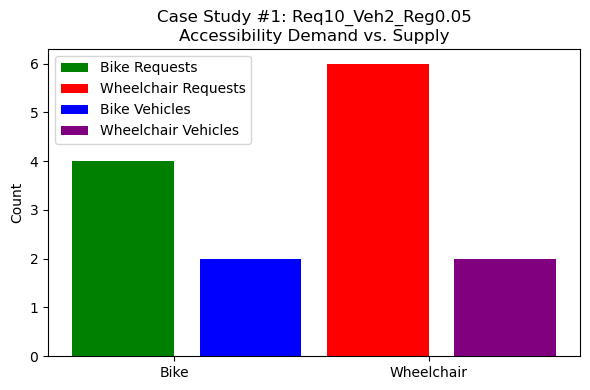

Chart Explanation: Compares the number of bike/wheelchair requests to the number of
vehicles equipped for each. If requests exceed available vehicles, some demands may go unmet.



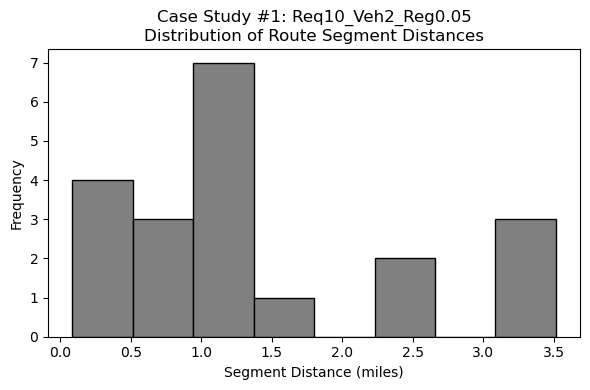

Chart Explanation: Shows how long individual route segments are. A tail of longer segments
suggests some rides are significantly farther apart, typical in rural contexts.



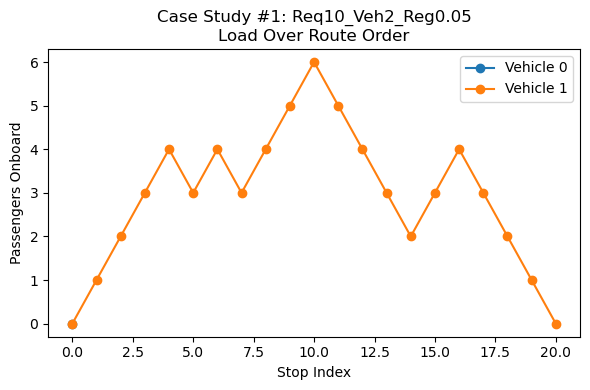

Chart Explanation: Depicts how each vehicle's passenger load changes stop by stop.
Helps identify if a vehicle quickly reaches capacity or remains underutilized.


--- Case Study #2: Req20_Veh4_Reg0.1 ---
Number of Requests: 20
Number of Vehicles: 4
Region Size: ±0.1 degrees
Total Distance (miles): 81.28
Simulation Time (minutes): 162.55
Bike Requests: 10, Wheelchair Requests: 8
Bike Vehicles: 2, Wheelchair Vehicles: 2


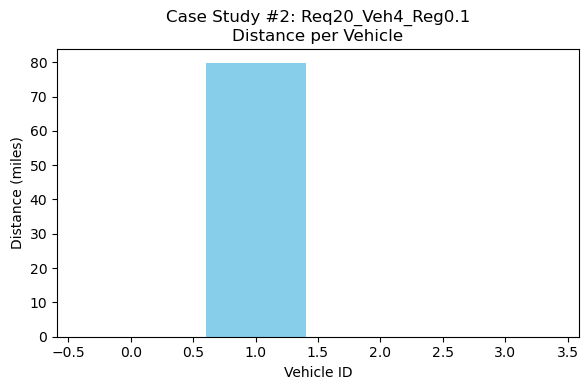

Chart Explanation: Shows how total route distance is distributed among vehicles.
A balanced distribution suggests efficient load-sharing, while large disparity indicates
certain vehicles handle more requests than others.



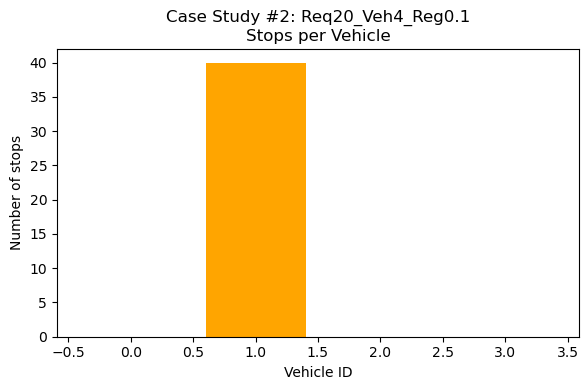

Chart Explanation: Shows how many pickups/dropoffs each vehicle performed.
It highlights whether requests are spread evenly or if certain vehicles do most of the work.



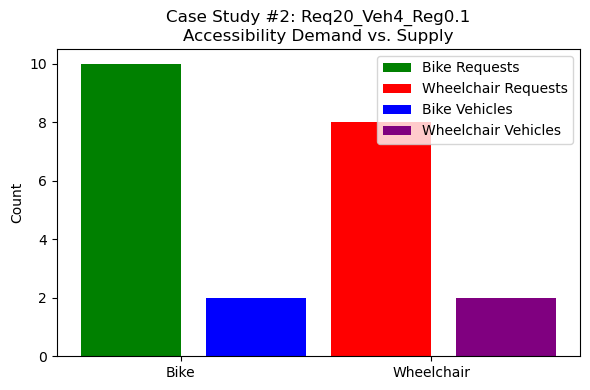

Chart Explanation: Compares the number of bike/wheelchair requests to the number of
vehicles equipped for each. If requests exceed available vehicles, some demands may go unmet.



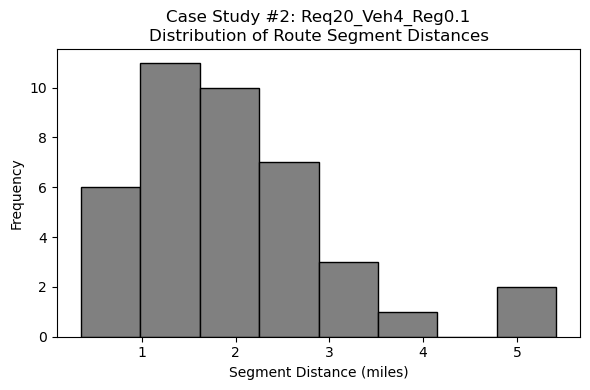

Chart Explanation: Shows how long individual route segments are. A tail of longer segments
suggests some rides are significantly farther apart, typical in rural contexts.



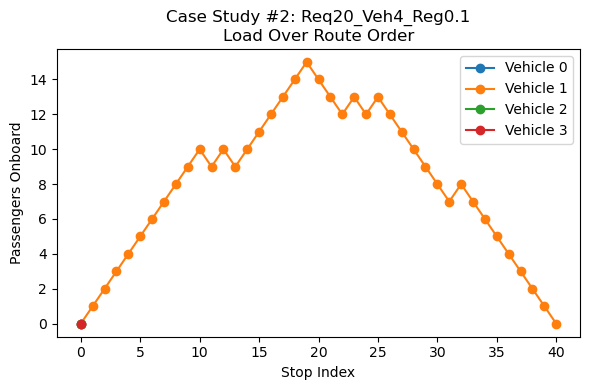

Chart Explanation: Depicts how each vehicle's passenger load changes stop by stop.
Helps identify if a vehicle quickly reaches capacity or remains underutilized.


--- Case Study #3: Req30_Veh6_Reg0.2 ---
Number of Requests: 30
Number of Vehicles: 6
Region Size: ±0.2 degrees
Total Distance (miles): 195.30
Simulation Time (minutes): 390.61
Bike Requests: 16, Wheelchair Requests: 13
Bike Vehicles: 5, Wheelchair Vehicles: 3


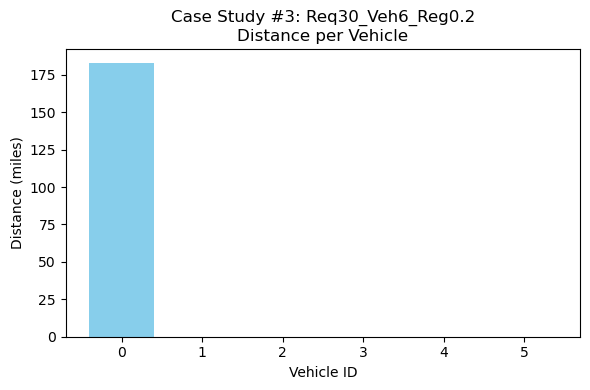

Chart Explanation: Shows how total route distance is distributed among vehicles.
A balanced distribution suggests efficient load-sharing, while large disparity indicates
certain vehicles handle more requests than others.



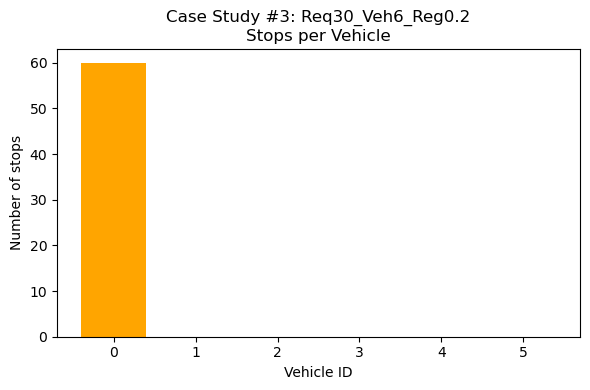

Chart Explanation: Shows how many pickups/dropoffs each vehicle performed.
It highlights whether requests are spread evenly or if certain vehicles do most of the work.



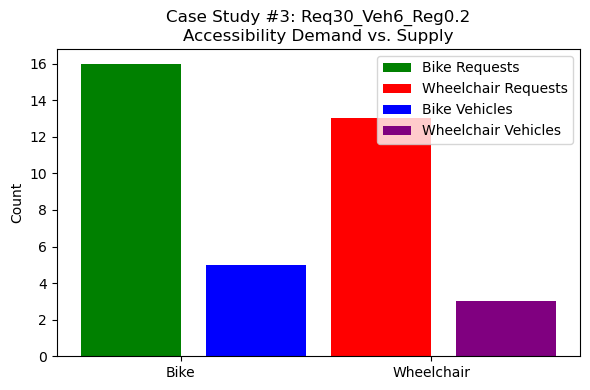

Chart Explanation: Compares the number of bike/wheelchair requests to the number of
vehicles equipped for each. If requests exceed available vehicles, some demands may go unmet.



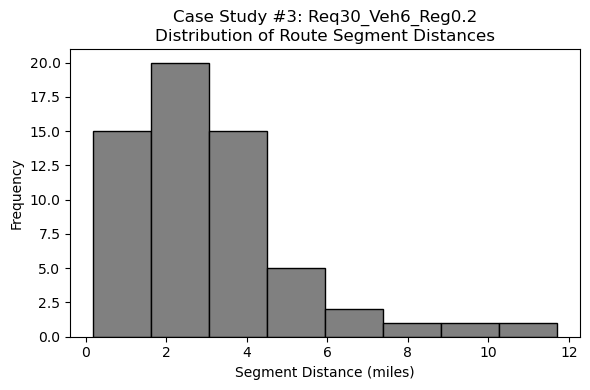

Chart Explanation: Shows how long individual route segments are. A tail of longer segments
suggests some rides are significantly farther apart, typical in rural contexts.



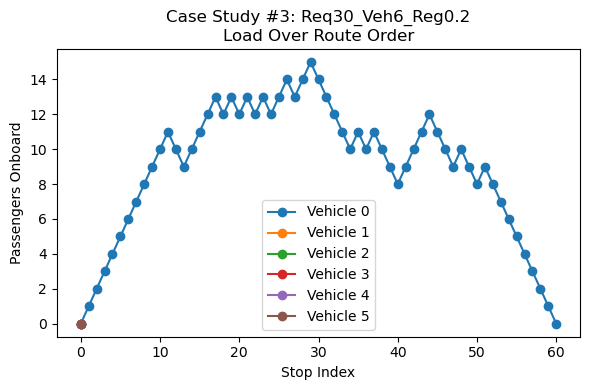

Chart Explanation: Depicts how each vehicle's passenger load changes stop by stop.
Helps identify if a vehicle quickly reaches capacity or remains underutilized.


================= CONCLUSION =================
Across the three case studies, we observe that as the region size and number of requests grow,
total route distance and simulation time increase, reflecting the higher complexity of serving
rural rides. Accessibility demands vary randomly, and when requests exceed the number of
accessible vehicles, constraints may limit feasible solutions. Overall, these results
demonstrate how the GoEverywhere algorithm scales with demand and region size while
managing accessibility needs in a rural context.



In [7]:
import sys
import random
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os

# Use perf_counter for high-resolution timing
from time import perf_counter

from ortools.constraint_solver import routing_enums_pb2, pywrapcp
from haversine import haversine, Unit
import folium
import osmnx as ox
import networkx as nx

# For Jupyter display if needed
IN_JUPYTER = 'ipykernel' in sys.modules
if IN_JUPYTER:
    from IPython.display import display

###############################################################################
# 1) SCENARIO DEFINITIONS (Case Studies)
###############################################################################
# We define three scenarios to reflect small, medium, and large region demands.
# Each scenario can be repeated or slightly changed if you want multiple runs.
TEST_CONFIGS = [
    # Case Study A: small region, fewer requests
    {"num_requests": 10, "num_vehicles": 2, "region_size": 0.05},
    # Case Study B: moderate region, moderate requests
    {"num_requests": 20, "num_vehicles": 4, "region_size": 0.1},
    # Case Study C: larger region, more requests
    {"num_requests": 30, "num_vehicles": 6, "region_size": 0.2},
]
TIME_LIMIT_SEC = 30  # Increase if needed

###############################################################################
# 2) DATA CREATION (RANDOM)
###############################################################################
def create_rural_data(num_requests=8, num_vehicles=3, region_size=0.1):
    """
    Generates a dial-a-ride problem with wide time windows and large capacities.
    Randomness ensures each run is unique. We do not fix seeds here.
    """
    import numpy as np
    center_lat, center_lon = 30.1897, -82.6393
    lat_range = region_size
    lon_range = region_size

    locations = [("Depot", center_lat, center_lon)]
    requests = []
    accessibility_requirements = {}

    for i in range(num_requests):
        pickup_lat = center_lat + random.uniform(-lat_range, lat_range)
        pickup_lon = center_lon + random.uniform(-lon_range, lon_range)
        dropoff_lat = center_lat + random.uniform(-lat_range, lat_range)
        dropoff_lon = center_lon + random.uniform(-lon_range, lon_range)

        # Full-day time windows
        window = (0, 1440)

        needs_bike = (random.random() < 0.5)
        needs_wheelchair = (random.random() < 0.5)
        
        req = {
            "name": f"R{i+1}",
            "pickup_lat": pickup_lat,
            "pickup_lon": pickup_lon,
            "dropoff_lat": dropoff_lat,
            "dropoff_lon": dropoff_lon,
            "time_window": window,
            "needs_bike": needs_bike,
            "needs_wheelchair": needs_wheelchair
        }
        requests.append(req)
    
    # Build location list
    for i, req in enumerate(requests):
        # pickup
        locations.append((f"{req['name']}_pickup", req["pickup_lat"], req["pickup_lon"]))
        # dropoff
        locations.append((f"{req['name']}_dropoff", req["dropoff_lat"], req["dropoff_lon"]))
        # Store accessibility for pickup node only
        accessibility_requirements[1 + 2*i] = (req["needs_bike"], req["needs_wheelchair"])
    
    data = {}
    data["num_vehicles"] = num_vehicles
    data["depot"] = 0
    # Large capacity to avoid capacity constraints overshadowing the test
    data["vehicle_capacities"] = [9999] * num_vehicles

    num_locs = len(locations)
    dist_mat = np.zeros((num_locs, num_locs))
    for i in range(num_locs):
        for j in range(num_locs):
            coord1 = (locations[i][1], locations[i][2])
            coord2 = (locations[j][1], locations[j][2])
            dist_mat[i][j] = haversine(coord1, coord2, unit=Unit.MILES)
    
    data["distance_matrix"] = (dist_mat * 1000).astype(int).tolist()
    # Time matrix based on 30 mph
    time_mat = (dist_mat / 30.0) * 60.0
    data["time_matrix"] = (time_mat * 1000).astype(int).tolist()
    
    data["demands"] = [0] * num_locs
    data["pickups_deliveries"] = []
    data["time_windows"] = []
    
    # Depot time window
    data["time_windows"].append((0, 1440))
    
    passenger_node_to_name = {}
    for i, req in enumerate(requests):
        pu_idx = 1 + 2*i
        do_idx = pu_idx + 1
        data["pickups_deliveries"].append([pu_idx, do_idx])
        data["demands"][pu_idx] = 1
        data["demands"][do_idx] = -1
        passenger_node_to_name[pu_idx] = req["name"]
        passenger_node_to_name[do_idx] = req["name"]
        data["time_windows"].append(req["time_window"])
        data["time_windows"].append(req["time_window"])
    
    # Vehicle accessibility with 50% chance each
    data["vehicles"] = []
    for v in range(num_vehicles):
        bike_capable = (random.random() < 0.5)
        wheelchair_accessible = (random.random() < 0.5)
        data["vehicles"].append({
            "bike_capable": bike_capable,
            "wheelchair_accessible": wheelchair_accessible
        })
    
    return data, locations, passenger_node_to_name, accessibility_requirements, requests

###############################################################################
# 3) SOLVE ROUTING
###############################################################################
def solve_routing(data, locations, passenger_node_to_name, accessibility_requirements,
                  fs_strategy="PCA", ls_heuristic="GLS", time_limit=60):
    """
    Solves the routing problem with no skipping. 
    Returns metrics and the route for each vehicle.
    """
    manager = pywrapcp.RoutingIndexManager(len(data["distance_matrix"]),
                                           data["num_vehicles"],
                                           data["depot"])
    routing = pywrapcp.RoutingModel(manager)
    
    def distance_callback(from_index, to_index):
        return data["distance_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    dist_cb_idx = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(dist_cb_idx)
    
    def demand_callback(from_index):
        return data["demands"][manager.IndexToNode(from_index)]
    demand_cb_idx = routing.RegisterUnaryTransitCallback(demand_callback)
    routing.AddDimensionWithVehicleCapacity(demand_cb_idx, 0,
                                            data["vehicle_capacities"],
                                            True, "Capacity")
    
    def time_callback(from_index, to_index):
        return data["time_matrix"][manager.IndexToNode(from_index)][manager.IndexToNode(to_index)]
    time_cb_idx = routing.RegisterTransitCallback(time_callback)
    routing.AddDimension(time_cb_idx, 30000, 24*60*60*1000, False, "Time")
    time_dim = routing.GetDimensionOrDie("Time")
    
    for loc_idx, tw in enumerate(data["time_windows"]):
        idx = manager.NodeToIndex(loc_idx)
        time_dim.CumulVar(idx).SetRange(tw[0]*60000, tw[1]*60000)
    
    # Pickup and Delivery
    for (pu_idx, do_idx) in data["pickups_deliveries"]:
        pu = manager.NodeToIndex(pu_idx)
        do = manager.NodeToIndex(do_idx)
        routing.AddPickupAndDelivery(pu, do)
        routing.solver().Add(routing.VehicleVar(pu) == routing.VehicleVar(do))
        routing.solver().Add(time_dim.CumulVar(pu) <= time_dim.CumulVar(do))
    
    # Accessibility constraints
    for pu_idx, (needs_bike, needs_wheelchair) in accessibility_requirements.items():
        allowed_vehicles = []
        for v, vehicle in enumerate(data["vehicles"]):
            if needs_bike and not vehicle["bike_capable"]:
                continue
            if needs_wheelchair and not vehicle["wheelchair_accessible"]:
                continue
            allowed_vehicles.append(v)
        if allowed_vehicles:
            routing.SetAllowedVehiclesForIndex(allowed_vehicles, manager.NodeToIndex(pu_idx))
    
    search_params = pywrapcp.DefaultRoutingSearchParameters()
    search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC
    search_params.local_search_metaheuristic = routing_enums_pb2.LocalSearchMetaheuristic.GUIDED_LOCAL_SEARCH
    search_params.time_limit.FromSeconds(time_limit)
    search_params.log_search = True
    
    solution = routing.SolveWithParameters(search_params)
    if not solution:
        print("No solution found!")
        return None, None
    
    # Extract routes
    routes = []
    for v in range(data["num_vehicles"]):
        index = routing.Start(v)
        route_nodes = []
        while not routing.IsEnd(index):
            route_nodes.append(manager.IndexToNode(index))
            index = solution.Value(routing.NextVar(index))
        routes.append(route_nodes)
    
    # Calculate total distance
    total_dist_miles = solution.ObjectiveValue() / 1000.0
    sim_time_min = (total_dist_miles / 30.0) * 60.0
    
    # Gather vehicle details
    vehicle_details = []
    route_segment_distances = []
    for v, route in enumerate(routes):
        route_dist = 0.0
        non_depot_stops = 0
        load_over_route = []
        current_load = 0
        for i in range(len(route)-1):
            from_node = route[i]
            to_node = route[i+1]
            dist_leg = data["distance_matrix"][from_node][to_node] / 1000.0
            route_dist += dist_leg
            route_segment_distances.append(dist_leg)
            current_load += data["demands"][from_node]
            load_over_route.append(current_load)
            if from_node != data["depot"]:
                non_depot_stops += 1
        if route:
            last_node = route[-1]
            current_load += data["demands"][last_node]
            load_over_route.append(current_load)
            if last_node != data["depot"]:
                non_depot_stops += 1
        vehicle_details.append({
            "vehicle_id": v,
            "route_distance": route_dist,
            "stops": non_depot_stops,
            "load_list": load_over_route
        })
    
    bike_requests = sum(1 for (b, w) in accessibility_requirements.values() if b)
    wheelchair_requests = sum(1 for (b, w) in accessibility_requirements.values() if w)
    bike_vehicles = sum(1 for v in data["vehicles"] if v["bike_capable"])
    wheelchair_vehicles = sum(1 for v in data["vehicles"] if v["wheelchair_accessible"])
    
    metrics = {
        "distance_miles": total_dist_miles,
        "sim_time_min": sim_time_min,
        "vehicle_details": vehicle_details,
        "segment_distances": route_segment_distances,
        "bike_requests": bike_requests,
        "wheelchair_requests": wheelchair_requests,
        "bike_vehicles": bike_vehicles,
        "wheelchair_vehicles": wheelchair_vehicles
    }
    return metrics, routes

###############################################################################
# 4) VISUALIZATION (MAP)
###############################################################################
def visualize_routes(routes, data, locations, passenger_node_to_name,
                     accessibility_requirements, vehicle_colors):
    """
    Creates a Folium map with always-visible labels (DivIcon).
    """
    from folium.features import DivIcon
    depot_lat, depot_lon = locations[0][1], locations[0][2]
    m = folium.Map(location=[depot_lat, depot_lon], zoom_start=10)

    # Attempt to create an OSM graph for route directions
    try:
        G = ox.graph_from_point((depot_lat, depot_lon), dist=30000, network_type='drive')
        G = G.to_undirected()
    except Exception as e:
        print("OSMnx error, using direct coords only:", e)
        G = None

    for v_idx, route in enumerate(routes):
        color = vehicle_colors[v_idx % len(vehicle_colors)]
        coords = [(locations[node_idx][1], locations[node_idx][2]) for node_idx in route]
        folium.PolyLine(coords, color=color, weight=3).add_to(m)
        
        # Label each stop with a DivIcon
        for stop_order, node_idx in enumerate(route, start=1):
            lat, lon = locations[node_idx][1], locations[node_idx][2]
            dem = data["demands"][node_idx]
            if dem == 1:
                point_type = "Pickup"
                request_name = passenger_node_to_name.get(node_idx, "?")
            elif dem == -1:
                point_type = "Dropoff"
                request_name = passenger_node_to_name.get(node_idx, "?")
            else:
                point_type = "Depot"
                request_name = "Depot"
            
            needs_bike, needs_wheelchair = accessibility_requirements.get(node_idx, (False, False))
            icon_str = ""
            if needs_bike:
                icon_str += " 🚲"
            if needs_wheelchair:
                icon_str += " ♿"
            
            label_text = f"Bus #{v_idx}, Stop #{stop_order}, {point_type} {request_name}{icon_str}"
            offset_lat = 0.00005
            offset_lon = 0.00005
            folium.map.Marker(
                location=(lat + offset_lat, lon + offset_lon),
                icon=DivIcon(
                    icon_size=(250, 36),
                    icon_anchor=(0, 0),
                    html=f"""
                    <div style="font-size: 10pt; 
                                color: white; 
                                background-color: {color}; 
                                opacity: 0.8;
                                border: 1px solid black; 
                                border-radius: 4px;
                                padding: 2px;">
                        {label_text}
                    </div>
                    """
                )
            ).add_to(m)
    
    return m

###############################################################################
# 5) BUILD RESULTS PAGE (HTML)
###############################################################################
def build_results_page(df, map_files, chart_file):
    html = "<html><head><title>Routing Results</title></head><body>"
    html += "<h1>Routing Test Results</h1>"
    html += "<p>Below are the aggregated metrics from our three case studies, each representing a distinct scenario in terms of number of requests, vehicles, and region size.</p>"
    html += "<h2>Aggregated Metrics</h2>"
    html += df.to_html(index=False)
    html += f"<h2>Comparison Chart (Basic)</h2><p>This bar chart compares total distance (left) and simulation time (right) across the scenarios. We see how the system scales with the number of requests and region size.</p>"
    html += f"<img src='{chart_file}' alt='Grouped Bar Chart' style='max-width:800px;'>"
    html += "<h2>Route Maps</h2><ul>"
    for cfg, mapfile in map_files.items():
        html += f"<li><a href='{mapfile}' target='_blank'>Config: {cfg}</a> - View the Folium map for this scenario.</li>"
    html += "</ul></body></html>"
    with open("results.html", "w") as f:
        f.write(html)
    print("Results page saved to results.html")

###############################################################################
# 6) ANALYZE AND PLOT (CHARTS WITH DESCRIPTIONS)
###############################################################################
def analyze_and_plot(all_runs_data):
    """
    Breaks down each scenario (case study) individually:
      - Distance per vehicle
      - Stops per vehicle
      - Accessibility demand vs. supply
      - Distribution of route segment distances
      - Load over route order
    Then prints a short overall conclusion.
    """
    import numpy as np
    
    # Print a general introduction for the analytics
    print("\n================= ANALYTICS & CASE STUDIES =================")
    print("Below we examine each case study (scenario) individually.\n")
    
    # Sort the scenarios for consistent ordering (optional)
    all_runs_data = sorted(all_runs_data, key=lambda x: x["Config"])
    
    for idx, scenario_data in enumerate(all_runs_data, start=1):
        # Identify scenario
        scenario_label = scenario_data["Config"]
        case_study_title = f"Case Study #{idx}: {scenario_label}"
        
        # Extract relevant data
        vehicle_details = scenario_data["vehicle_details"]
        v_dists = [v["route_distance"] for v in vehicle_details]
        v_stops = [v["stops"] for v in vehicle_details]
        segment_dists = scenario_data["segment_distances"]
        
        bike_req = scenario_data["bike_requests"]
        wc_req = scenario_data["wheelchair_requests"]
        bike_veh = scenario_data["bike_vehicles"]
        wc_veh = scenario_data["wheelchair_vehicles"]
        
        # Print scenario summary
        print(f"\n--- {case_study_title} ---")
        print(f"Number of Requests: {scenario_data['NumRequests']}")
        print(f"Number of Vehicles: {scenario_data['NumVehicles']}")
        print(f"Region Size: ±{scenario_data['RegionSize']} degrees")
        print(f"Total Distance (miles): {scenario_data['distance_miles']:.2f}")
        print(f"Simulation Time (minutes): {scenario_data['sim_time_min']:.2f}")
        print(f"Bike Requests: {bike_req}, Wheelchair Requests: {wc_req}")
        print(f"Bike Vehicles: {bike_veh}, Wheelchair Vehicles: {wc_veh}")
        
        # 1) Distance per Vehicle
        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar(range(len(v_dists)), v_dists, color='skyblue')
        ax.set_title(f"{case_study_title}\nDistance per Vehicle")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Distance (miles)")
        plt.tight_layout()
        plt.show()
        print("Chart Explanation: Shows how total route distance is distributed among vehicles.\n"
              "A balanced distribution suggests efficient load-sharing, while large disparity indicates\n"
              "certain vehicles handle more requests than others.\n")
        
        # 2) Stops per Vehicle
        fig, ax = plt.subplots(figsize=(6,4))
        ax.bar(range(len(v_stops)), v_stops, color='orange')
        ax.set_title(f"{case_study_title}\nStops per Vehicle")
        ax.set_xlabel("Vehicle ID")
        ax.set_ylabel("Number of stops")
        plt.tight_layout()
        plt.show()
        print("Chart Explanation: Shows how many pickups/dropoffs each vehicle performed.\n"
              "It highlights whether requests are spread evenly or if certain vehicles do most of the work.\n")
        
        # 3) Accessibility Demand vs. Supply (Single Scenario)
        # We do a small grouped bar for just this scenario
        fig, ax = plt.subplots(figsize=(6,4))
        bars_x = [0, 1]  # We'll just place two sets of bars side by side
        # Demand
        ax.bar(bars_x[0], bike_req, width=0.4, label="Bike Requests", color='green')
        ax.bar(bars_x[1], wc_req, width=0.4, label="Wheelchair Requests", color='red')
        # Supply
        ax.bar(bars_x[0]+0.5, bike_veh, width=0.4, label="Bike Vehicles", color='blue')
        ax.bar(bars_x[1]+0.5, wc_veh, width=0.4, label="Wheelchair Vehicles", color='purple')
        
        ax.set_xticks([0.2, 1.2])
        ax.set_xticklabels(["Bike", "Wheelchair"])
        ax.set_ylabel("Count")
        ax.set_title(f"{case_study_title}\nAccessibility Demand vs. Supply")
        ax.legend()
        plt.tight_layout()
        plt.show()
        print("Chart Explanation: Compares the number of bike/wheelchair requests to the number of\n"
              "vehicles equipped for each. If requests exceed available vehicles, some demands may go unmet.\n")
        
        # 4) Distribution of Route Segment Distances
        fig, ax = plt.subplots(figsize=(6,4))
        ax.hist(segment_dists, bins=8, color='gray', edgecolor='black')
        ax.set_title(f"{case_study_title}\nDistribution of Route Segment Distances")
        ax.set_xlabel("Segment Distance (miles)")
        ax.set_ylabel("Frequency")
        plt.tight_layout()
        plt.show()
        print("Chart Explanation: Shows how long individual route segments are. A tail of longer segments\n"
              "suggests some rides are significantly farther apart, typical in rural contexts.\n")
        
        # 5) Load Over Route Order
        # We'll pick just one vehicle's load list or show all in lines
        fig, ax = plt.subplots(figsize=(6,4))
        for vinfo in vehicle_details:
            v_id = vinfo["vehicle_id"]
            load_list = vinfo["load_list"]
            ax.plot(range(len(load_list)), load_list, marker='o', label=f"Vehicle {v_id}")
        ax.set_title(f"{case_study_title}\nLoad Over Route Order")
        ax.set_xlabel("Stop Index")
        ax.set_ylabel("Passengers Onboard")
        ax.legend()
        plt.tight_layout()
        plt.show()
        print("Chart Explanation: Depicts how each vehicle's passenger load changes stop by stop.\n"
              "Helps identify if a vehicle quickly reaches capacity or remains underutilized.\n")
    
    # Final Conclusion
    print("\n================= CONCLUSION =================")
    print("Across the three case studies, we observe that as the region size and number of requests grow,\n"
          "total route distance and simulation time increase, reflecting the higher complexity of serving\n"
          "rural rides. Accessibility demands vary randomly, and when requests exceed the number of\n"
          "accessible vehicles, constraints may limit feasible solutions. Overall, these results\n"
          "demonstrate how the GoEverywhere algorithm scales with demand and region size while\n"
          "managing accessibility needs in a rural context.\n")


###############################################################################
# 7) MAIN: RUN CASE STUDIES, PLOT, & GENERATE RESULTS
###############################################################################
def main():
    all_runs = []
    map_files = {}
    
    for config in TEST_CONFIGS:
        num_requests = config["num_requests"]
        num_vehicles = config["num_vehicles"]
        region_size = config["region_size"]
        config_label = f"Req{num_requests}_Veh{num_vehicles}_Reg{region_size}"
        print(f"\n=== Running test config: {config_label} ===")
        
        # Create random data for this scenario
        data, locations, passenger_node_to_name, accessibility_requirements, requests = \
            create_rural_data(num_requests=num_requests,
                              num_vehicles=num_vehicles,
                              region_size=region_size)
        
        # Solve routing
        metrics, routes = solve_routing(data, locations, passenger_node_to_name,
                                        accessibility_requirements,
                                        fs_strategy="PCA", ls_heuristic="GLS",
                                        time_limit=TIME_LIMIT_SEC)
        if metrics is None:
            continue
        
        # Store scenario-level info
        metrics.update({
            "Config": config_label,
            "NumRequests": num_requests,
            "NumVehicles": num_vehicles,
            "RegionSize": region_size,
            "requests": requests
        })
        all_runs.append(metrics)
        
        # Create a map for each scenario
        ts = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
        mapfile = f"routes_{config_label}_{ts}.html"
        vehicle_colors = ['red', 'blue', 'green', 'purple', 'orange']
        my_map = visualize_routes(routes, data, locations, passenger_node_to_name,
                                  accessibility_requirements, vehicle_colors)
        my_map.save(mapfile)
        map_files[config_label] = mapfile
        
        # Display inline if in Jupyter
        if IN_JUPYTER:
            display(my_map)
    
    if not all_runs:
        print("No solutions found for any configuration!")
        return
    
    # Build a DataFrame of the main metrics for each scenario
    df = pd.DataFrame([
        {
            "Config": r["Config"],
            "NumRequests": r["NumRequests"],
            "NumVehicles": r["NumVehicles"],
            "RegionSize": r["RegionSize"],
            "distance_miles": r["distance_miles"],
            "sim_time_min": r["sim_time_min"]
        } for r in all_runs
    ])
    
    print("\n--- Raw Results (All Configurations) ---")
    print(df)
    
    # Basic bar charts for total distance & sim time
    df_indexed = df.set_index("Config")
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    df_indexed["distance_miles"].plot(kind="bar", ax=axes[0], rot=45, width=0.5)
    axes[0].set_title("Total Distance (miles)")
    axes[0].set_ylabel("Miles")
    
    df_indexed["sim_time_min"].plot(kind="bar", ax=axes[1], rot=45, width=0.5)
    axes[1].set_title("Simulation Time (min)")
    axes[1].set_ylabel("Minutes")
    plt.tight_layout()
    chart_filename = "grouped_comparison.png"
    plt.savefig(chart_filename)
    plt.show()
    print(f"Basic grouped bar chart saved to {chart_filename}")
    
    # Build HTML results page
    build_results_page(df, map_files, chart_filename)
    
    # Create additional analysis & charts with textual explanations
    analyze_and_plot(all_runs)

if __name__ == "__main__":
    main()
